# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet import plotting

plt.style.use("ggplot")

In [2]:
def plot_pseudopressure(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(0, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, 1), ylim=(0,1.05))
    return fig, ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


## Ideal gas simulation

In [3]:
t_end = 6
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

CPU times: user 4.85 s, sys: 16.3 ms, total: 4.87 s
Wall time: 4.86 s


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

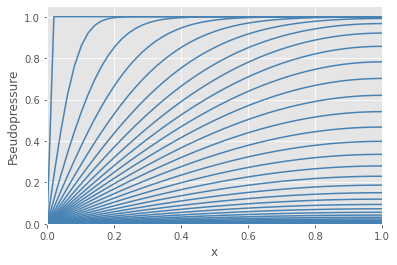

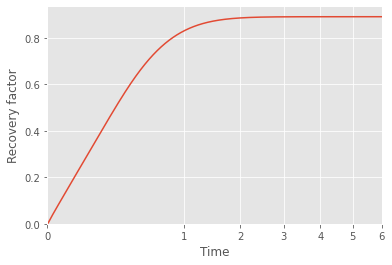

In [4]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

## Real gas simulation

<AxesSubplot:xlabel='pseudopressure', ylabel='diffusivity'>

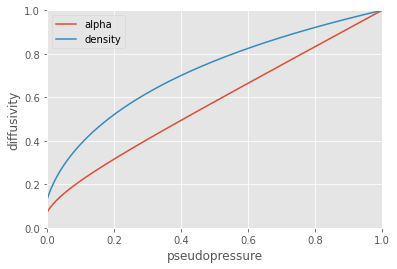

In [5]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1/(x.Cg * x.Viscosity), 
        density=lambda x: x.Density/max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min()) / 
            (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(
        alpha=lambda x: x.alpha/x.alpha.iloc[-1]
    )[["pseudopressure", "alpha", "density"]]
    return out

fluid_properties = (
    pvt_gas[pvt_gas.P>=1000]
    .pipe(scale_pressure_diffusivity)
)
ax = fluid_properties.plot(x='pseudopressure', y="alpha")
ax.set(ylim=(0,1), xlim=(0,1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax)

In [6]:
flow_properties = FlowProperties(fluid_properties, fvf_scale=0.3579)

res_realgas = SinglePhaseReservoir(50, 1000, 12000, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

CPU times: user 5.58 s, sys: 177 µs, total: 5.58 s
Wall time: 5.58 s


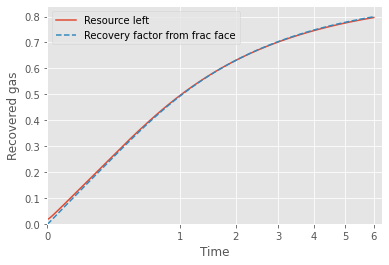

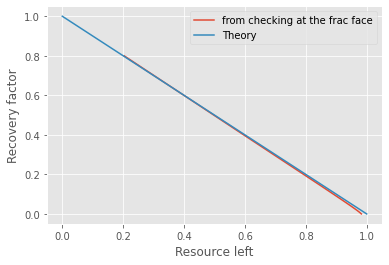

In [7]:
from scipy import interpolate
density_interp = interpolate.interp1d(fluid_properties["pseudopressure"], fluid_properties["density"])
def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt["pseudopressure"], pvt["density"])
    return (density(pseudopressure)).sum(axis=1)
remaining_gas = resource_left(res_realgas.pseudopressure, fluid_properties) / res_realgas.nx
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gas, label="Resource left")
ax.plot(time, rf2,"--", label="Recovery factor from frac face")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

fig, ax = plt.subplots()
ax.plot(remaining_gas, rf2 , label="from checking at the frac face")
ax.plot([1,0], [0,1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 0.9352331895079818),
 None,
 (0.0, 6.299999999999999)]

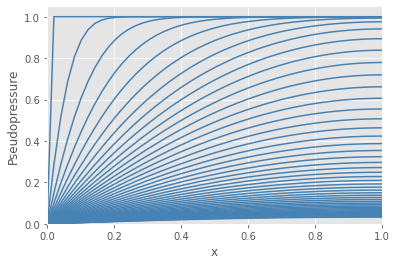

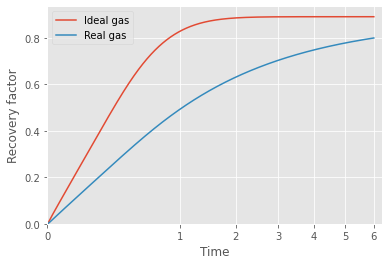

In [8]:
ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovery factor", ylim=(0,None), xscale='squareroot', xlim=(0,None))

## Multiphase flow

### Set up PVT

[(1000.0, 6000.0), (0.0, 1.0), Text(0, 0.5, 'Value')]

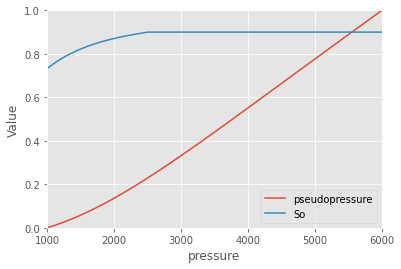

In [9]:
# set conditions
Sw = 0.1
p_frac = 1000
p_res = 6_000
phi = 0.1
fvf_scale = 1

# get pvt tables
pvt_oil = pd.read_csv("../tests/data/pvt_oil.csv")
pvt_water = (
    pd.read_csv("../tests/data/pvt_water.csv")
    .rename(columns={"T":"temperature","P":"pressure","Viscosity":"mu_w"})
)
df_pvt = (
    pvt_water.drop(columns=["temperature"])
    .merge(pvt_oil.rename(columns={
        "T":"temperature","P":"pressure",'Oil_Viscosity':"mu_o","Gas_Viscosity":"mu_g","Rso":"Rs"
    }), on="pressure")
    .assign(Rv=0)
)

# calculate So, Sg assuming no mobile water
df_pvt_mp = df_pvt.copy()
df_pvt_mp['So'] = (1 - Sw) / ((df_pvt['Rs'].max() - df_pvt['Rs']) * df_pvt['Bg'] / df_pvt['Bo'] / 5.61458 + 1)

# scale pseudopressure
pseudopressure = interp1d(df_pvt.pressure, df_pvt.pseudopressure)
df_pvt_mp['pseudopressure'] = (
    (pseudopressure(df_pvt_mp['pressure']) - pseudopressure(p_frac))
     / (pseudopressure(p_res) - pseudopressure(p_frac))
)

fig, ax = plt.subplots()
df_pvt_mp.plot(x='pressure', y='pseudopressure', ax=ax)
df_pvt_mp.plot(x='pressure', y='So', ax=ax)
ax.set(xlim=(p_frac, p_res), ylim=(0,1.), ylabel="Value")

### Set up relative permeabilities

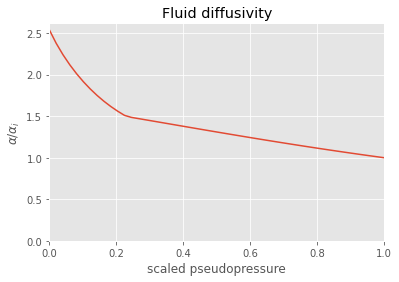

In [10]:
relperm_params = RelPermParams(
    n_o=1, n_g=1, n_w=1, S_or=0, S_gc=0, S_wc=0.1, k_ro_max=1, k_rw_max=1, k_rg_max=1
)
saturations_test = pd.DataFrame(
    {"So": np.linspace(0,0.9), "Sw":np.full(50, 0.1), "Sg":np.linspace(0.9,0)}
)
kr_matrix = pd.DataFrame(relative_permeabilities(
    saturations_test.to_records(index=False), relperm_params
))
df_kr = pd.concat([saturations_test, kr_matrix], axis=1)
reference_densities = {"rho_o0":141.5/(45+131.5), "rho_g0":1.03e-3, "rho_w0":1}
flow_props = FlowPropertiesTwoPhase.from_table(
    df_pvt_mp, df_kr, reference_densities, phi, Sw, fvf_scale
)
m_scaled = np.linspace(0, 1)
fig, ax = plt.subplots()
ax.plot(m_scaled, flow_props.alpha(m_scaled) / flow_props.alpha(1))
ax.set(
    xlim=(0,1), 
    ylim=(0,None), 
    xlabel="scaled pseudopressure",  
    ylabel=r"$\alpha/\alpha_i$", 
    title="Fluid diffusivity",
);

### Simulate

In [11]:
res = SinglePhaseReservoir(50, p_frac, p_res, flow_props)
t_end = 3
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
res.simulate(time)
rf = res.recovery_factor()

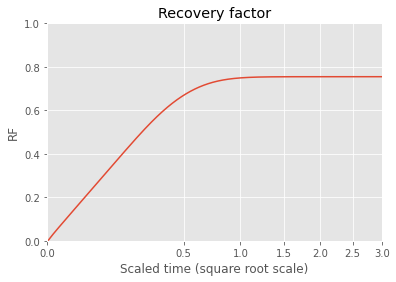

In [12]:
fig, ax = plt.subplots()
ax.plot(time, rf)
ax.set(
    xscale='squareroot', 
    xlim=(0,t_end), 
    ylim=(0,1), 
    ylabel="RF", 
    title='Recovery factor', 
    xlabel="Scaled time (square root scale)"
);